In [42]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader,random_split
from torchvision import transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt 
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [43]:
class VanillaNN(nn.Module):
    
    def __init__(self,input_layer_size,hidden_layer_size,hidden_layer_2_size,output_layer_size):
        super(VanillaNN,self).__init__()
        self.first=nn.Linear(input_layer_size,hidden_layer_size)
        self.relu_func=nn.ReLU()
        self.second=nn.Linear(hidden_layer_size,output_layer_size)
        # self.relu_func=nn.ReLU()
        # self.third=nn.Linear(hidden_layer_2_size,output_layer_size)
        self.soft_layer=nn.Softmax(dim=1)
        # code here
    def forward(self,x):
        # code here
        output = self.first(x)
        output = self.relu_func(output)
        output = self.second(output)
        # output = self.relu_func(output)
        # output = self.third(output)
        output = self.soft_layer(output)
        return output

In [44]:
f=open("processed_data.txt","w")
count=0
with open("data.txt","r") as file:
  for line in file:
    if line[0] not in ["\n","X","T","%","M","K","P","S","L","V"]:
      f.write(line)



with open('processed_data.txt', 'r') as file:
    text = file.read()


vocabulary = sorted(set(text))


char_to_index = {char: index for index, char in enumerate(vocabulary)}
index_to_char = {index: char for index, char in enumerate(vocabulary)}



one_hot_encodings = []
for letter in text:
    index = char_to_index[letter]
    one_hot = torch.zeros(len(vocabulary))
    one_hot[index] = 1
    one_hot_encodings.append(one_hot)


# Convert the list of tensors into a single tensor
one_hot_encodings = torch.stack(one_hot_encodings)

# Print the resulting tensor
print(one_hot_encodings.size())

torch.Size([89864, 52])


In [45]:
window_size = 50 # number of last nodes considered
stride = 1  # number of last nodes considered

X = []
Y = []

for i in range(0, len(one_hot_encodings) - window_size, stride):
    window = one_hot_encodings[i:i + window_size]
    target = one_hot_encodings[i + window_size]

    X.append(window)
    Y.append(target)

X = torch.stack(X)
Y = torch.stack(Y)



In [46]:
X.size()

torch.Size([89814, 50, 52])

In [47]:
new_shape = (-1, window_size * len(vocabulary))
X_reshaped = torch.reshape(X, new_shape)


In [48]:
Y.size()

torch.Size([89814, 52])

In [49]:
X_reshaped.size()

torch.Size([89814, 2600])

In [50]:
X_reshaped_ongpu= X_reshaped.to(device)
Y_ongpu = Y.to(device)
# print("X_reshaped shape:", X_reshaped.shape)

In [51]:
input_layer_size=len(vocabulary) * window_size
hidden_layer_size=1000    #2500
hidden_layer_2_size=1000
output_layer_size=len(vocabulary)
learning_rate=0.00001
model = VanillaNN(input_layer_size,hidden_layer_size,hidden_layer_2_size,output_layer_size).to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [52]:
Y.size()

torch.Size([89814, 52])

In [53]:
def predict(sequence,model,length):
  for i in range(length):
    index_seq = []
    for i in sequence:
      index_seq.append(char_to_index[i])
    one_hot_encodings = []
    for letter in index_seq:
        one_hot = torch.zeros(len(vocabulary))
        one_hot[letter] = 1
        one_hot_encodings.append(one_hot)
    
    one_hot_encodings = torch.stack(one_hot_encodings)
    new_shape = (-1, window_size * len(vocabulary))
    X_test = torch.reshape(one_hot_encodings, new_shape)
    X_test=X_test.to(device)
    output=model(X_test)
    ind=torch.argmax(output).to('cpu')
    char_new=str(index_to_char[ind.item()])
    sequence=sequence[1:]+char_new
    # print(ind)
    print(index_to_char[ind.item()],end="")




In [54]:
X_reshaped_ongpu[0].size()

torch.Size([2600])

In [55]:
from google.colab import files

def train(X_reshaped_ongpu, epochs=100):

    losses = []
    epoches = []
    for epoch in range(epochs):
        epoches.append(epoch+1)
  
        _loss = []
        _acc = []

        for i in range(0,len(X_reshaped_ongpu),128):  
            optimizer.zero_grad()

            outputs = model(X_reshaped_ongpu[i:i+1])
            loss = criterion(outputs, Y_ongpu[i:i+1])    

            loss.backward()
            optimizer.step()
            _loss.append(loss.item())

        losses.append(np.average(_loss))
        print('Epoch {}: loss = {}'.format(epoch + 1, _loss[-1]))

        if (epoch+1)%20 ==0 :
          file_name='model_params'+str(epoch+1)+".pth"
          torch.save(model.state_dict(), file_name)
          print(loss/len(X_reshaped_ongpu))
        # files.download(file_name)
      # loss.item()

    return epoches, losses
epoches, losses = train(X_reshaped_ongpu)

Epoch 1: loss = 3.9509761333465576
Epoch 2: loss = 3.948002576828003
Epoch 3: loss = 3.9449245929718018
Epoch 4: loss = 3.952538013458252
Epoch 5: loss = 3.9634718894958496
Epoch 6: loss = 3.9682774543762207
Epoch 7: loss = 3.9697372913360596
Epoch 8: loss = 3.9692986011505127
Epoch 9: loss = 3.9676880836486816
Epoch 10: loss = 3.9660592079162598
Epoch 11: loss = 3.9654831886291504
Epoch 12: loss = 3.965749502182007
Epoch 13: loss = 3.9663350582122803
Epoch 14: loss = 3.9670560359954834
Epoch 15: loss = 3.967912197113037
Epoch 16: loss = 3.968886375427246
Epoch 17: loss = 3.969907283782959
Epoch 18: loss = 3.970869541168213
Epoch 19: loss = 3.971721649169922
Epoch 20: loss = 3.9724502563476562
tensor(4.4230e-05, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 21: loss = 3.9730658531188965
Epoch 22: loss = 3.973598003387451
Epoch 23: loss = 3.9740617275238037
Epoch 24: loss = 3.9744696617126465
Epoch 25: loss = 3.9748313426971436
Epoch 26: loss = 3.9751505851745605
Epoch 27: loss = 3.975

In [56]:
def visualizeLosses(epochs, losses):
    
    plt.xlabel('Epoch') 
    plt.ylabel('Loss') 
    plt.title("Loss vs Epoch - Vanilla") 
    plt.plot(epochs, losses, label = "Loss")
    # plt.plot(epochs, accuracies, label = "Accuracy")
    # plt.legend(loc='upper right')
    plt.show()
    print()

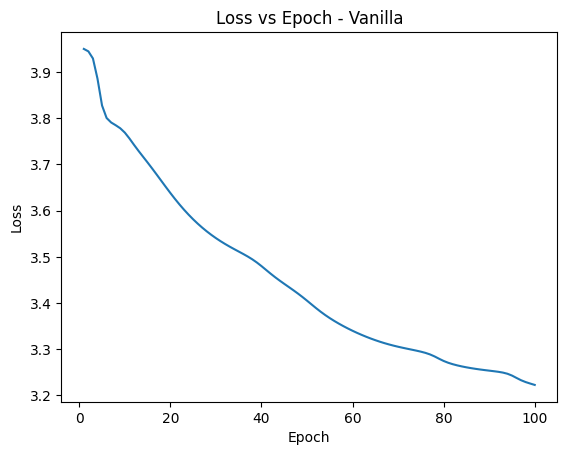

In [57]:
visualizeLosses(epoches, losses)

In [58]:
start_index = np.random.randint(len(text)-window_size-2)

input = text[start_index:start_index+window_size]
predict(input,model,150)

"cBc ccB|"D"ccA "cc|BA"cdB c2c|"G"|"ccc|"A"cBcdcBccccBcBcBc|"cccccc"ccc|"cc"ccc ccc|"c"ccc c|"|"cccccccc|cBccccc|cccccc|"cc|ccc|"ccccccccc|cc|c|ccc|cc

In [59]:
start_index = np.random.randint(len(text)-window_size-2)

input = text[start_index:start_index+window_size]
predict(input,model,150)

e"A"A|Ac|"B"G2d d2c|Gc cccc"Bc" "cc"ccGcccc"c"cc"c"ccdccc|"cccccc|"cccccccccc|"Bcc|cc|c|cccc|"ccc|cc|"ccc|cAccc|"ccc|ccc|"ccccccccc|"ccccccc|ccc|"c"cc